In [2]:
# %pip install ipympl
%matplotlib widget

In [3]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}
.jupyter-matplotlib-header {
   color: white
}
.jupyter-matplotlib-footer {
   color: white
}
</style>

In [4]:
import torch 
from torch.utils.data import Dataset, DataLoader
import numpy as np
import wfdb
import matplotlib.pyplot as plt
import matplotlib
import scipy as sc

In [5]:
plt.rcParams.update({
    "figure.facecolor": (1.0, 1.0, 1.0, 0.0),
    "text.color": "white",
    "axes.labelcolor" : "white",
    "xtick.color": "white",
    "ytick.color": "white"
})

### Spectrogram test

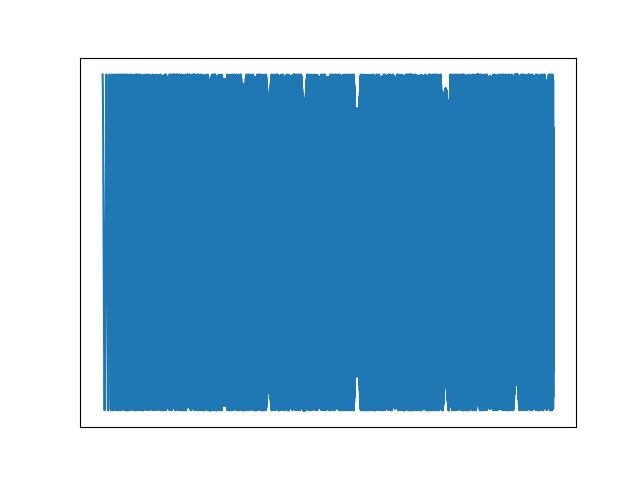

In [6]:
from scipy.signal import chirp

T = 10
Ts = 0.001
t = np.arange(0,T,Ts)
signal = chirp(t, f0=10, t1=8, f1=350, method='linear')

plt.figure()
plt.plot(t, signal)
plt.show()

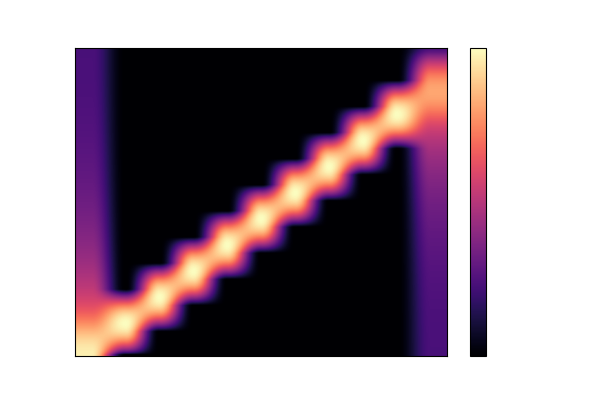

In [7]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

w_T = 1
w_N = int(w_T / Ts)
g_std = 8
w = gaussian(w_N, std=g_std, sym=True)
SFT = ShortTimeFFT(w, hop=w_N, fs=(1/Ts), scale_to='magnitude')
Sx2 = SFT.spectrogram(signal)

fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit
Sx_dB = 10 * np.log10(np.fmax(Sx2, 1e-4))  # limit range to -40 dB
im1 = ax1.imshow(Sx_dB, origin='lower', aspect='auto',
                 extent=SFT.extent(T), cmap='magma')
fig1.colorbar(im1, label='Power Spectral Density ' +
              r"$20\,\log_{10}|S_x(t, f)|$ in dB")
plt.show();

### WFDB

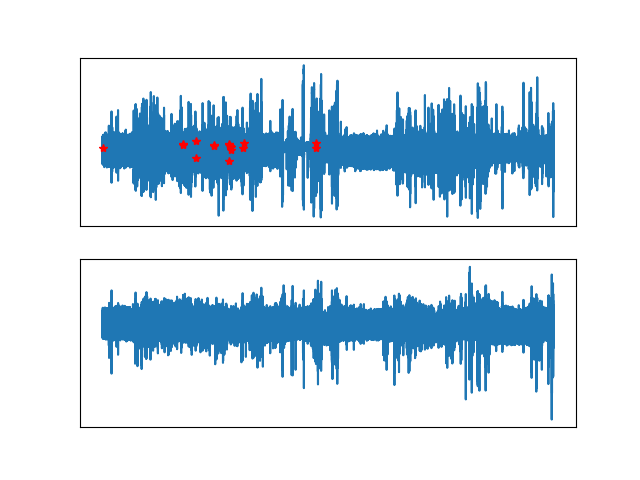

In [8]:
import wfdb.processing

record = wfdb.rdrecord('Data/mit_bih_atrial_fibrillation_database/files/05091')
annotation = wfdb.rdann('Data/mit_bih_atrial_fibrillation_database/files/05091', 'atr')

wfdb.plot_wfdb(record=record, annotation=annotation)

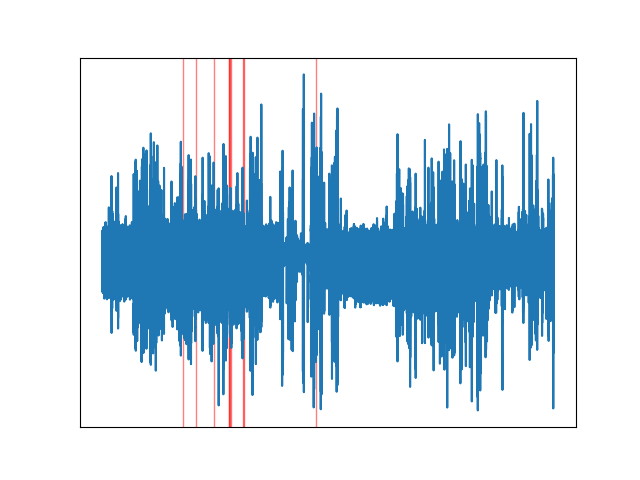

In [9]:
ann_labels = annotation.aux_note
ann_samples = annotation.sample
waveform = record.p_signal

afib_mask = np.zeros(waveform.shape[0])
ranges_N = []
ranges_AFIB = []
for i, label in enumerate(ann_labels):
    if i != (len(ann_labels) - 1):
        if label == '(AFIB':
            afib_mask[ann_samples[i]:ann_samples[i+1]] = 1
            ranges_AFIB.append([ann_samples[i], ann_samples[i+1]])
        else:
            ranges_N.append([ann_samples[i], ann_samples[i+1]])
    else:
        if label == '(AFIB':
            afib_mask[ann_samples[i]:] = 1
            ranges_AFIB.append([ann_samples[i], (waveform.shape[0]-1)])
        else:
            ranges_N.append([ann_samples[i], (waveform.shape[0]-1)])

ranges_AFIB = np.array(ranges_AFIB)
ranges_N = np.array(ranges_N)

fig, ax = plt.subplots()
ax.plot(waveform[:,0]);
for x1, x2 in ranges_AFIB:
    ax.axvspan(x1, x2, alpha=0.5, color='red')
plt.show();

### WFDB spectrogram

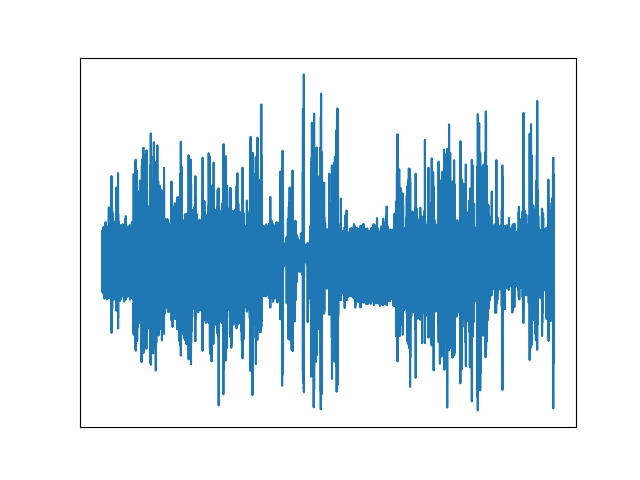

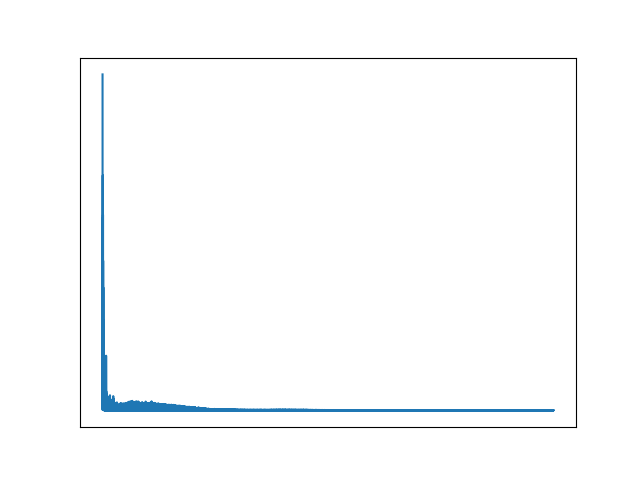

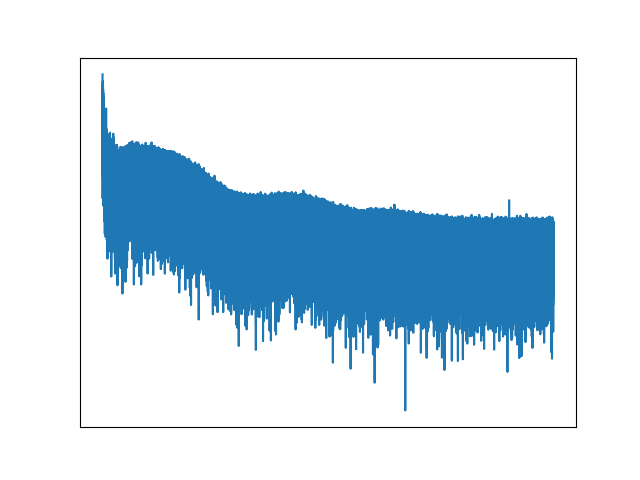

In [10]:
from scipy.fft import fft, fftfreq

record = wfdb.rdrecord('Data/mit_bih_atrial_fibrillation_database/files/05091')
waveform = record.p_signal[ann_samples[0]:, 0]

N = waveform.shape[0]
fs = record.fs
dt = 1/fs
T = dt*N

y = fft(waveform)
f = fftfreq(N, dt)[:N//2]

plt.figure()
plt.plot(waveform)
plt.show()
plt.figure()
plt.plot(f, 2/N * np.abs(y[:N//2]))
plt.show()
plt.figure()
plt.plot(f, 20*np.log10(2/N * np.abs(y[:N//2])))
plt.show()

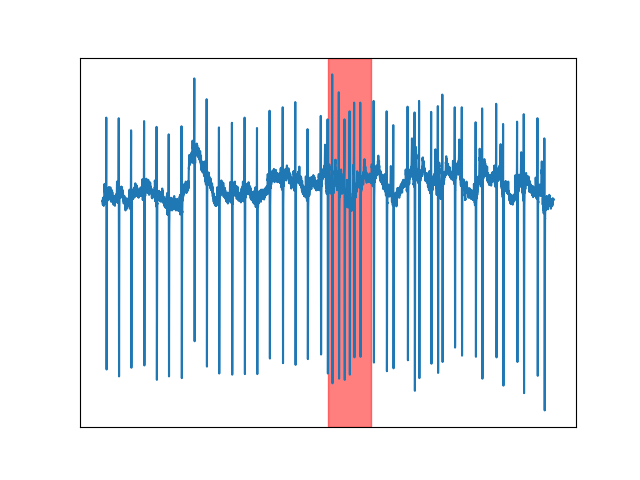

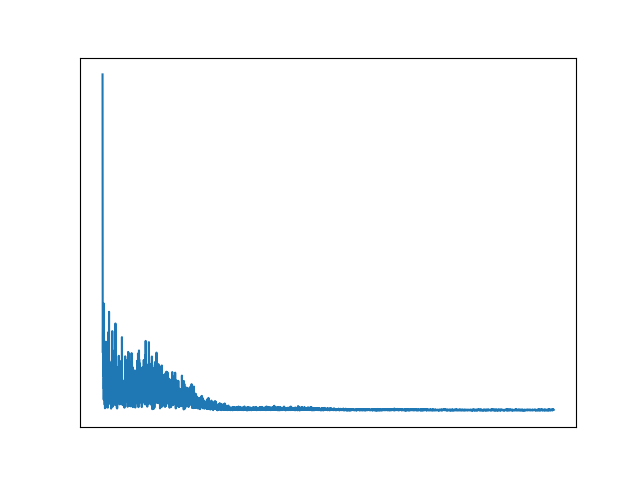

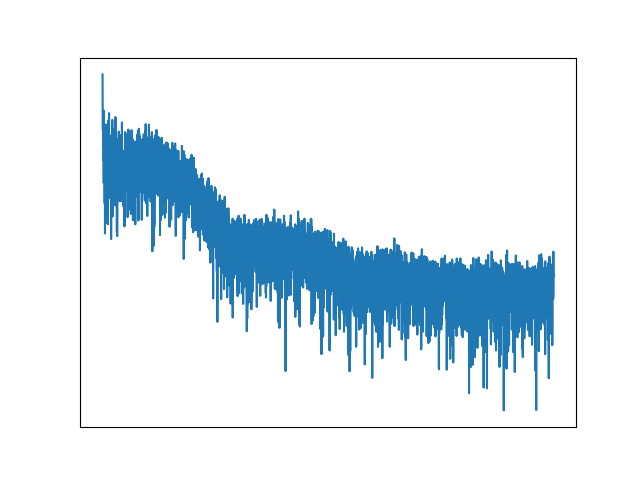

In [11]:
N = 10000
n1 = int(ann_samples[1] - N/2)
n2 = int(ann_samples[1] + N/2)

window = waveform[n1:n2]
t = np.linspace(0, N*dt, N)

y = fft(window)
M = 2/N * np.abs(y[:N//2])
f = fftfreq(N, dt)[:N//2]

fig, ax = plt.subplots()
ax.plot(t, window);
x1, x2 = ranges_AFIB[0]
ax.axvspan(dt*(N/2), dt*(N/2+(x2-x1)), alpha=0.5, color='red')
plt.show();

plt.figure()
plt.plot(f, M)
plt.show();

plt.figure()
plt.plot(f, 20*np.log10(M))
plt.show();

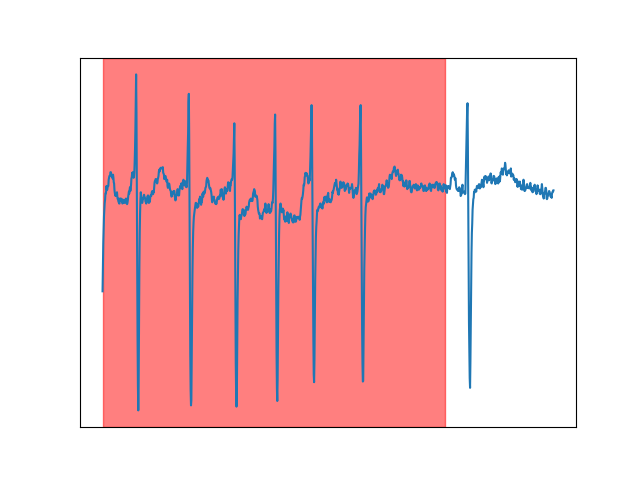

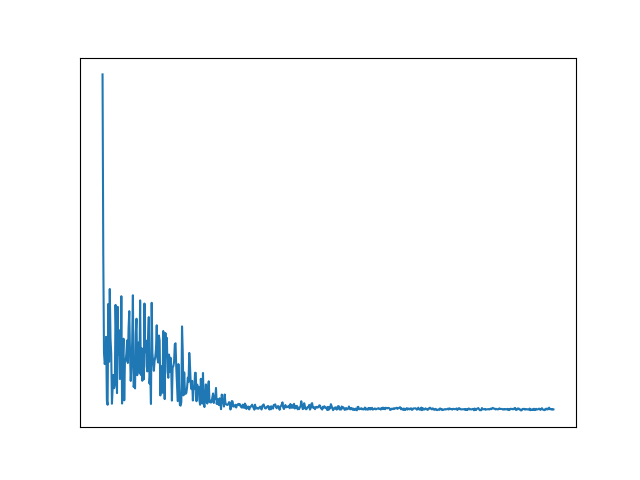

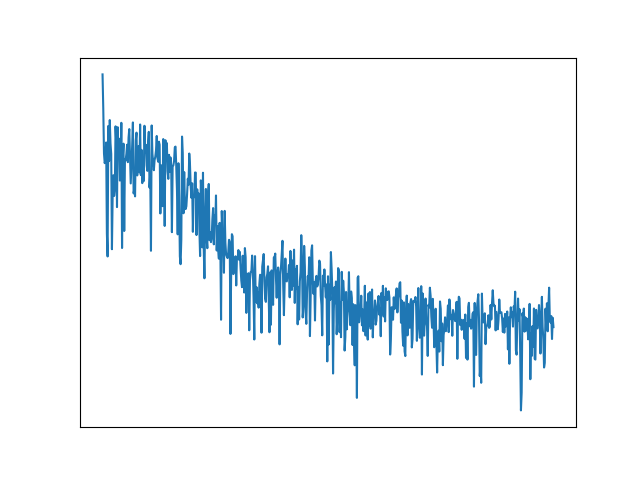

In [12]:
N = int(5 / dt)
n1 = int(ann_samples[1])
n2 = int(ann_samples[1] + N)

slice = waveform[n1:n2]
t = np.linspace(0, N*dt, N)

y = fft(slice)
M = 2/N * np.abs(y[:N//2])
f = fftfreq(N, dt)[:N//2]

fig, ax = plt.subplots()
ax.plot(t, slice);
x1, x2 = ranges_AFIB[0]
ax.axvspan(0, dt*(x2-x1), alpha=0.5, color='red')
plt.show();

plt.figure()
plt.plot(f, M)
plt.show();

plt.figure()
plt.plot(f, 20*np.log10(M))
plt.show();

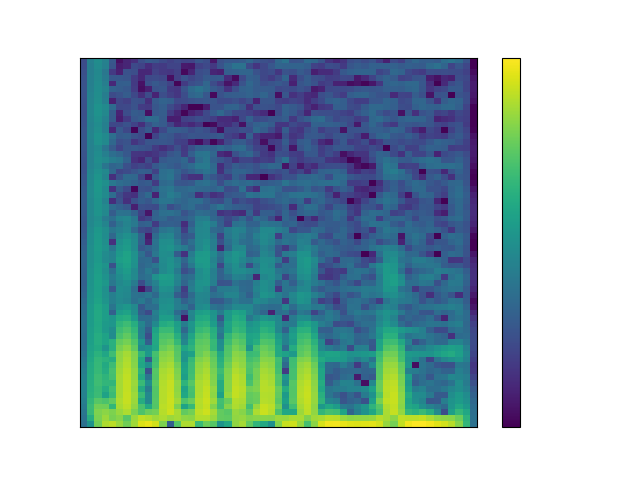

In [13]:
from scipy.signal.windows import hamming

w_N = 125
w = hamming(w_N, True)

SFT = ShortTimeFFT(w, w_N//5, fs)
Sx2 = SFT.spectrogram(slice)
Sx_dB = 10 * np.log10(np.fmax(Sx2, 1e-4))

fig, ax = plt.subplots()
im = ax.imshow(Sx_dB, origin='lower', aspect='auto',
               extent=SFT.extent(N), cmap='viridis')
fig.colorbar(im, label='Power Spectral Density ' +
              r"$20\,\log_{10}|S_x(t, f)|$ in dB");
plt.show()

### Npz dataset

['afib1', 'afib2', 'afib3', 'afib4', 'afib5', 'afib6', 'afib7', 'afib8', 'afib9', 'afib10', 'afib11', 'afib12', 'afib13', 'afib14', 'afib15', 'afib16', 'afib17', 'afib18']
['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19', 'n20', 'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29', 'n30', 'n31', 'n32', 'n33', 'n34', 'n35', 'n36', 'n37', 'n38', 'n39', 'n40', 'n41', 'n42', 'n43', 'n44', 'n45', 'n46', 'n47', 'n48', 'n49', 'n50', 'n51', 'n52', 'n53', 'n54', 'n55', 'n56', 'n57', 'n58', 'n59', 'n60', 'n61', 'n62', 'n63', 'n64', 'n65', 'n66', 'n67', 'n68', 'n69', 'n70', 'n71', 'n72', 'n73', 'n74', 'n75', 'n76', 'n77', 'n78', 'n79', 'n80', 'n81', 'n82', 'n83', 'n84', 'n85', 'n86', 'n87', 'n88', 'n89', 'n90', 'n91', 'n92', 'n93', 'n94', 'n95', 'n96', 'n97', 'n98', 'n99', 'n100', 'n101', 'n102', 'n103', 'n104', 'n105', 'n106', 'n107', 'n108', 'n109', 'n110', 'n111', 'n112', 'n113', 'n114', 'n115', 'n116', 'n117',

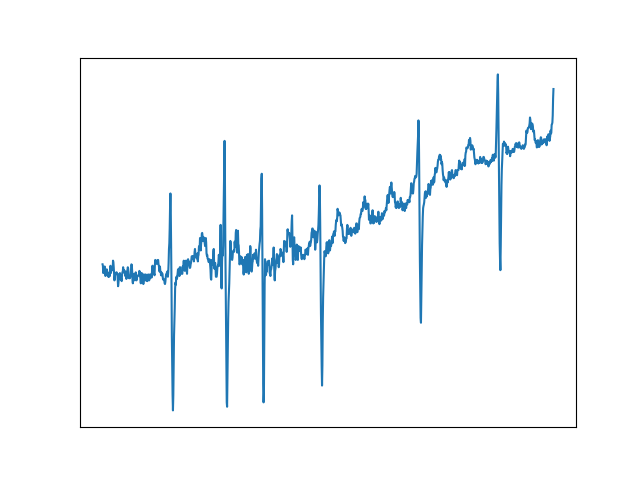

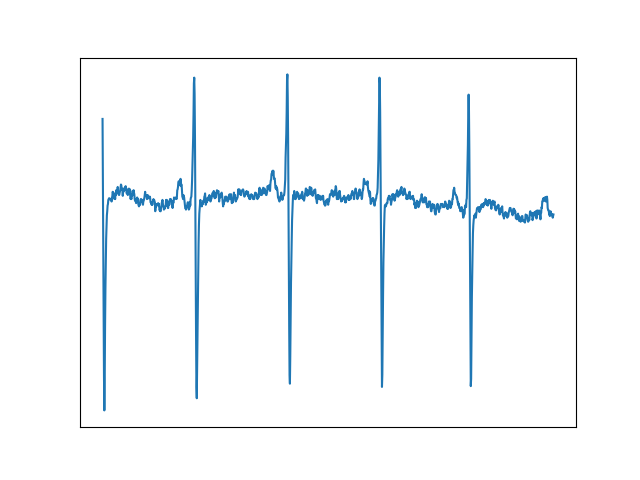

In [ ]:
afib_slices = np.load("Data/train_dataset/afib_samples/afib_samples_record_05091.npz", mmap_mode='r')
n_slices = np.load("./Data/train_dataset/n_samples/n_samples_record_05091.npz", mmap_mode='r')

print(afib_slices.files)
print(n_slices.files)

plt.figure()
plt.plot(afib_slices['afib10'])
plt.show()
plt.figure()
plt.plot(n_slices['n36'])
plt.show()